# Rover project
Roberto Lucchesi - 1744941

# Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# custom modules
from graph import *
from AStar import *
from grid import *
from traj_gen import *
from rover import *
from utils import *
from localization import *

dataFolder = "data/"

## Constants of the problem
maxVel = 0.04; # [m/s] maximum velocity of the rover 
LAxis = 3; # [m] length of the rover wheel axis


In [2]:

### load data from csv file
# landmarks coordinates
P0 = (42.38*10**3, 11.59*10**3)
P1 = (33.07*10**3, 19.01*10**3)
P2 = (38.80*10**3, 25.00*10**3)
Xlm = np.loadtxt(dataFolder +"Xlm.csv")
Ylm = np.loadtxt(dataFolder +"Ylm.csv")
pos_lm = np.array([Xlm, Ylm]).T # landmark positions

# map and obstacle map
mars_map = np.loadtxt(dataFolder +"map.csv", delimiter=",")
obstacle_map = np.loadtxt(dataFolder +"obstacle.csv", delimiter=",")

sup_map = map_obstacle(mars_map, obstacle_map)

# Create mars_grid (45kmx30km, 10m resolution)
mars_grid = Grid(xlim = 45000, ylim = 30000, res = 10, 
            image = sup_map, obstacle = obstacle_map, 
            landmarks = pos_lm, corner = 'll') 


#plt.imshow(np.flipud(mars_grid.map), cmap='gray')
#plt.gca().invert_yaxis()
#plt.show()

# Task 1
- 1.1) Plot the trajectory of the rover in the map from P0 = (42.38, 11.59)km to P1 = (33.07,19.01)km
- 1.2) Plot the velocity profile of the rover
- 1.3) Plot the steering angle profile of the rover
- 1.4) Plot the rate of change of the steering angle profile of the rover

In [3]:
# A* algorithm from P0 to P1
path, gScore = AStar(mars_grid, P0, P1) # Run A* from P0 to P1
np_path = np.array(path)
print("A* cost: ", gScore)

A* cost:  12383.46463280844


In [4]:
# Find trajectory via manual tuning of control_pose gains

Curiosity_rover = Rover(maxVel, LAxis)

np_P0 = np.array([P0[0],P0[1], np.deg2rad(90)])
np_P1 = np.array([P1[0],P1[1], np.deg2rad(180)])

q, qd, t  = control_pose(Curiosity_rover, np_P0, np_P1, 1, 
                         k_rho=0.04, k_alpha=0.09, k_beta=-0.115)


cost_traj = cost_path(q[:,0:2])


theta_plot =  list_np_angle(q[:,2])
theta_dot_plot = np.unwrap(qd[:,2])
print("Theta_final: ",theta_plot[-1])
print("Cost: ", cost_traj)
print("Time of trajectory: ", t)
print("Time in sol: ", t/sol_in_secs)



Stable: k_rho, k_alpha, k_beta = (0.04, 0.09, -0.115)
Theta_final:  179.9999779726177
Cost:  13244.482120523948
Time of trajectory:  331147
Time in sol:  3.7301727883970917


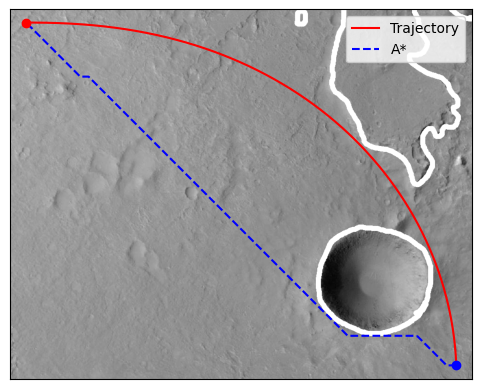

In [5]:

### - 1.1) Plot the trajectory of the rover in the map from 
###        P0 = (42.38, 11.59)km to P1 = (33.07,19.01)km

# Create submap around midpoint between P0 and P1
x_mid, y_mid = (P0[0]+P1[0])/2, (P0[1]+P1[1])/2

x_start, x_end = x_mid - 5000, x_mid + 5000
y_start, y_end = y_mid - 4000, y_mid + 4000

# Create submap
submap = mars_grid.get_submap(x_start, x_end, y_start, y_end)
submap.plot()

plt.plot(q[:,0]/10 - x_start/10, q[:,1]/10-y_start/10, 'r')

plt.plot(np_path[:,0]/10 - x_start/10, np_path[:,1]/10-y_start/10, 'b', linestyle='--')
plt.plot(P0[0]/10 - x_start/10, P0[1]/10-y_start/10, 'bo')
plt.plot(P1[0]/10 - x_start/10, P1[1]/10-y_start/10, 'ro')
plt.legend(['Trajectory', 'A*'])


plt.show()



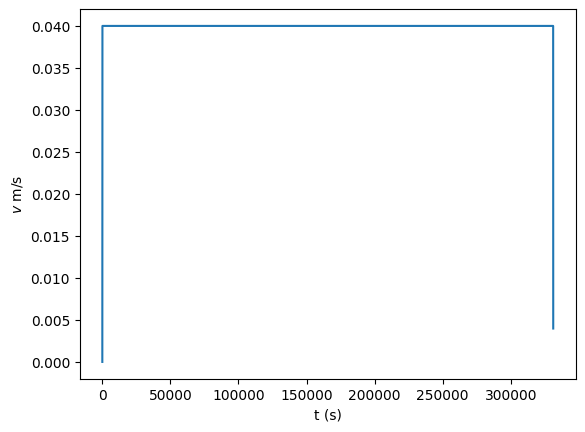

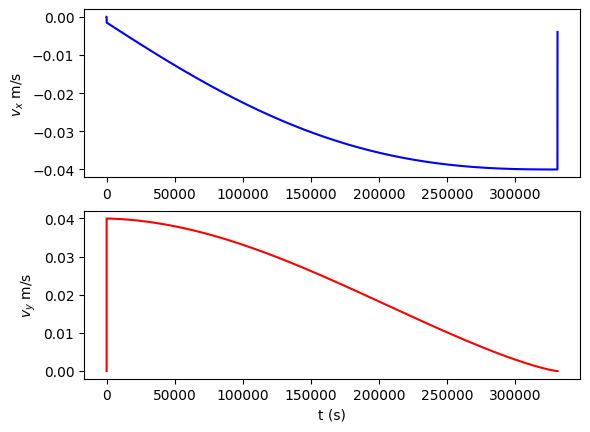

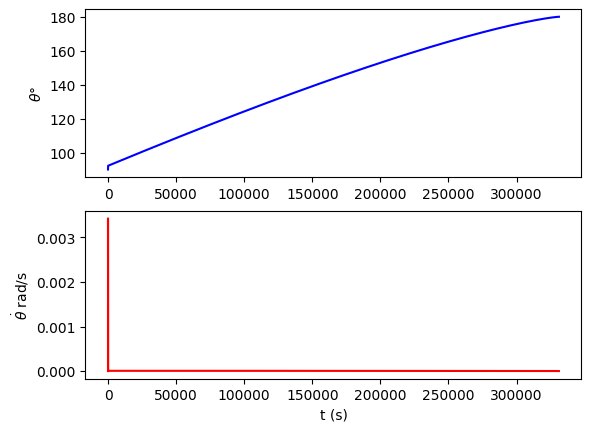

In [6]:

### 1.2) Plot the velocity profile of the rover
# plot velocity module
plt.figure()
plt.plot(np.sqrt(qd[:,0]**2 + qd[:,1]**2))
plt.ylabel(r'$v$' + " m/s")
plt.xlabel("t (s)")

# plot velocity components
plt.figure()
plt.subplot(2,1,1)
plt.ylabel(r'$v_x$' + " m/s")
plt.plot(qd[:,0], 'b-')
plt.subplot(2,1,2)
plt.ylabel(r'$v_y$' + " m/s")
plt.xlabel("t (s)")
plt.plot(qd[:,1], 'r-')

### 1.3) Plot the steering angle profile of the rover
plt.figure()
plt.subplot(2,1,1)
plt.ylabel(r'$\theta$' + "°")
plt.plot(theta_plot, 'b-')

### 1.4) Plot the rate of change of the steering angle profile of the rover
plt.subplot(2,1,2)
plt.ylabel(r'$\dot{\theta}$' + " rad/s")
plt.xlabel("t (s)")
plt.plot(theta_dot_plot, 'r-')
plt.show()





# Task 2

In [7]:
### TASK 2 ### -- 3min average runtime
# Go from P1 to P2

# Run A* from P0 to P1

# P2 = (10.87*10**3, 25.67*10**3)

# path2, gScore2 = AStar(mars_grid, P1, P2) # Run A* from P1 to P2
# np_path2 = np.array(path2)



In [8]:
# ## Plot TASK 2
# # Plot path
# plt.plot(np_path[:,0]/10, np_path[:,1]/10, 'b')
# plt.plot(np_path2[:,0]/10, np_path2[:,1]/10, 'r')

# mars_grid.plot()
# plt.plot(P0[0]/10, P0[1]/10, 'bo')
# plt.plot(P1[0]/10, P1[1]/10, 'ro')
# plt.plot(P2[0]/10, P2[1]/10, 'go')

# plt.text(P0[0]/10, P0[1]/10+50, 'P0', color='blue', fontsize=12)
# plt.text(P1[0]/10, P1[1]/10+70, 'P1', color='red', fontsize=12)
# plt.text(P2[0]/10, P2[1]/10+70, 'P2', color='green', fontsize=12)

# plt.show()
# print("Cost from P0 to P1: ", gScore)
# print("Cost from P1 to P2: ", gScore2)
# print("Total cost: ", gScore + gScore2)


# Task 3

In [9]:
### TASK 3 ### 

## Dead reckoning with odomoter only
# We have a trajectory q integrated each 1s, and the odometer has
# a frequency of 1hz, so we're good

r_traj = q # trajectory of the rover

# Stdev on initial rover position
sigma_x = 6 # [m] standard deviation of the rover position
sigma_y = 6 # [m] *standard deviation of the rover position
sigma_theta = np.deg2rad(1) # [rad] standard deviation of the rover orientation

# odometer noise 
sigma_d  = 4*10**(-3) # [m] standard deviation of the distance measurement
sigma_phi = np.deg2rad(0.05) # [rad] standard deviation of the angle measurement

p0 = np.eye(3)*[sigma_x**2, sigma_y**2, sigma_theta**2] # initial covariance matrix


q_hat, p_hat = dead_recon(r_traj, p0, sigma_d, sigma_phi)

    

sigma_x_hat = np.sqrt(p_hat[:,0,0])
sigma_y_hat = np.sqrt(p_hat[:,1,1])



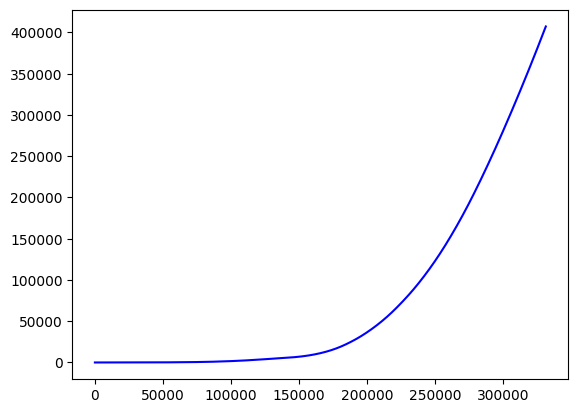

In [10]:
# Do some funny stuff with the covariance matrix 
# to plot the confidence interval

# 99.7% confidence interval
det_p1 = np.zeros(len(p_hat))

for i in range(len(p_hat)):
    det_p1[i] = np.sqrt(np.linalg.det(p_hat[i,:,:]))

plt.figure()
plt.plot(det_p1, 'b')

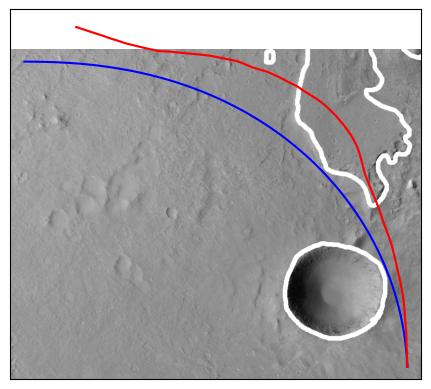

In [11]:
submap.plot()
# Plot real trajectory 

plt.plot(q_hat[:,0]/10 - submap.x_off/10, q_hat[:,1]/10 - submap.y_off/10, 'r', alpha=0.2)



plt.plot(r_traj[:,0]/10 - submap.x_off/10, r_traj[:,1]/10 - submap.y_off/10, 'b')
plt.plot(q_hat[:,0]/10- submap.x_off/10, q_hat[:,1]/10 - submap.y_off/10, 'r')

# Plot 3 sigma ellipse of the rover position



plt.show()

In [ ]:
# Dead reckoning with odomoter + landmark measurements
lidar_range = 500 # [m] maximum range of the lidar
sigma_rho = 0.1 # [m] standard deviation of the rho measurement
sigma_beta = np.deg2rad(0.25) # [rad] standard deviation of the beta measurement
# problematic landmark at [array([37482., 18113.])]
# first landmark at [array([41542., 15452.])] -- idx = 89663

ekf_traj, ekf_p = EKF(mars_grid, r_traj, p0, sigma_d, sigma_phi, sigma_rho, sigma_beta, lidar_range)



In [ ]:
submap.plot()

punto_scagato = r_traj[89770,: ]
plt.plot(punto_scagato[0]/10 - submap.x_off/10, punto_scagato[1]/10 - submap.y_off/10, 'ro')
print(np.linalg.norm(punto_scagato[0:2] - np.array([41542, 15452])))
plt.plot(41542/10 - submap.x_off/10, 15452/10 - submap.y_off/10, 'go')


In [ ]:
plt.plot(q_hat[:,2])
plt.show()

In [ ]:
plt.figure()
det_p = np.zeros(len(ekf_p))
for i in range(len(ekf_p)):
    det_p[i] = np.sqrt(np.linalg.det(ekf_p[i]))
plt.plot(det_p)
 

In [ ]:
submap.plot()
for landmark in submap.landmarks:
    plt.plot(landmark[0]/10 - submap.x_off/10, landmark[1]/10 - submap.y_off/10, 'yo')
# Plot real trajectory 
plt.plot(P0[0]/10 - submap.x_off/10, P0[1]/10 - submap.y_off/10, 'bo')
plt.plot(P1[0]/10 - submap.x_off/10, P1[1]/10 - submap.y_off/10, 'ro')    

plt.plot(r_traj[:,0]/10 - submap.x_off/10, r_traj[:,1]/10 - submap.y_off/10, 'b')
plt.plot(ekf_traj[:,0]/10- submap.x_off/10, ekf_traj[:,1]/10 - submap.y_off/10, 'g')


# Plot 3 sigma ellipse of the rover position



plt.show()